In [ ]:
!pip install tensorflow
!pip install numpy
!pip install matplotlib
!pip install imageio
!pip install tensorflow-addons

In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



# IMPORTS

In [ ]:
import os
import cv2
import re
import PIL
import time
import glob
import imageio
import scipy.misc
import numpy as np
from random import sample
import matplotlib.pyplot as plt
from scipy.stats import itemfreq
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow_addons.optimizers import RectifiedAdam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from IPython import display

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Helper Functions

## Timer

In [ ]:
def print_time(start):
    total_time = time.time() - start
    minutes = total_time/60
    seconds = total_time%60
    if minutes<1: minutes=0
    minutes, seconds = round(minutes), round(seconds, 2)
    print(f"This took {minutes} minutes and {seconds} seconds")

## Load in data

In [ ]:
# Normalize images between 0-1
def norm_image(img):
    img = np.clip(img/255,0,1)
    img = img.astype(np.float32)
    return img
# Normalize between -1 - 1
def negnorm_image(img):
    img = np.clip((img-127.5)/127.5,-1,1)
    img = img.astype(np.float32)
    return img

In [ ]:
# Put the training images into a dictionary where 
# Key: Val
# Breed: [Image1, Image2, ...]
def prep_data(directory):
    start_time = time.time()
    p = re.compile('[a-z]+')
    processed_data = {}
    for filename in os.listdir(directory):
        newname = p.match(filename)[0]
        processed_data.setdefault(newname,[])
        img = cv2.resize(cv2.imread(os.path.join(directory,filename)),(126,126), interpolation=cv2.INTER_LINEAR)
        img = negnorm_image(img)
        # img = norm_image(img)
        processed_data[newname].append(img)
        # to double our dataset size and sort of add more variance slightly to our data
        # dont want to only recognize a pug if it faces to the right
        processed_data[newname].append(cv2.flip(img,1))
    print_time(start_time)
    return processed_data

In [ ]:
path = 'drive/My Drive/data/processed_data/processed_data'
processed_data = prep_data(path)

This took 0 minutes and 5.98 seconds


In [ ]:
# Grab our test images and labels for them
test_images_path = os.path.join(os.getcwd(), 'drive/My Drive/data/testimages')
test_images, test_labels = [], []
p = re.compile('[a-z]+')
for img in os.listdir(test_images_path):
    newname = p.match(img)[0]
    test_labels.append(newname)
    i = cv2.imread(os.path.join(test_images_path,img))
    i = negnorm_image(cv2.resize(i,(126,126), interpolation=cv2.INTER_LINEAR))
    test_images.append(i)
test_images, test_labels = np.asarray(test_images), np.asarray(test_labels)

## Split data into images and labels

In [ ]:
def setup_traindata(data):
    imgs, labels = [], []
    for key,val in processed_data.items():
        for img in val:
            labels.append(key)
            imgs.append(img)
            
    return np.asarray(imgs), np.asarray(labels)

In [ ]:
images, labels = setup_traindata(processed_data)

In [ ]:
print("Train Labels Shape:", labels.shape)
print("Train Images Shape:", images.shape)
print("Test Labels Shape:", test_labels.shape)
print("Train Images Shape:",test_images.shape)

Train Labels Shape: (2532,)
Train Images Shape: (2532, 126, 126, 3)
Test Labels Shape: (35,)
Train Images Shape: (35, 126, 126, 3)


## One hot encode label

In [ ]:
# General function for setting up one-hot encoding for any type of list of strings
# In this case we have 5 breeds so our return vector is n x 5
def one_hot_encode(labels):
      labels_bin=np.array([])
      labels_name, labels_ = np.unique(labels, return_inverse=True)

      for _, i in enumerate(itemfreq(labels_)[:,0].astype(int)):
          labels_bin0 = np.where(labels_ == itemfreq(labels_)[:,0][i], 1., 0.)
          labels_bin0 = labels_bin0.reshape(1,labels_bin0.shape[0])
          if (labels_bin.shape[0] == 0):
              labels_bin = labels_bin0
          else:
              labels_bin = np.concatenate((labels_bin,labels_bin0 ),axis=0)

      print("Number of Variables {0}".format(itemfreq(labels_)[:,0].shape[0]))
      labels_bin = labels_bin.transpose()
      print("Shape : {0}".format(labels_bin.shape))
      
      return labels_name, labels_bin

In [ ]:
labels_name, labels_bin = one_hot_encode(labels = labels)

Number of Variables 6
Shape : (2532, 6)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  from ipykernel import kernelapp as app


In [ ]:
test_labels_name, test_labels_bin = one_hot_encode(labels = test_labels)

Number of Variables 5
Shape : (35, 5)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  from ipykernel import kernelapp as app


### Create dictionaries to easily convert between index and label name

In [ ]:
# For future use so we can easily tell what is being inputted/outputted
def make_index_dictionaries(labels_name):
    label2index, index2label = {}, {}
    for i in range(len(labels_name)):
        name = labels_name[i]
        # have to add this line because of an issue while downloading
        if name == 'great': name = 'great dane'
        label2index[name] = i
        index2label[i] = name
    return label2index, index2label

In [ ]:
label2index, index2label = make_index_dictionaries(labels_name)

In [ ]:
print(label2index)

{'beagle': 0, 'great dane': 1, 'maltese': 2, 'pug': 3, 'redbone': 4}


## Data Generator

In [ ]:
def create_data_generator():
    data_gen = ImageDataGenerator(
        data_format = 'channels_last',
        validation_split = .2,
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        )
    return data_gen

## Plot evaluate functions

In [ ]:
def plot_evaluate(training_result, model, X_test, y_test):
    m_t = training_result.history
    num_epochs = len(m_t['loss'])
    fig, ax = plt.subplots(1, 2, figsize=(8,8), sharex=True)
    
    axs, axs2 = ax[0], ax[1]

    axs.set_ylim([0,1])
    axs.set_title('Accuracy')
    axs.set_xlabel('Epochs')
    axs2.set_title('Loss')
    axs2.set_xlabel('Epochs')
    
    for metric in m_t:
        if 'lr' in metric:
            continue
        elif 'loss' in metric:
            axs2.plot(np.arange(0, num_epochs), m_t[metric], label=metric)
        else:
            axs.plot(np.arange(0, num_epochs), m_t[metric], label=metric)
    try:
        print("max model validation accuracy: ", max(m_t['val_acc']))
    except:
        print("max model validation accuracy: ", max(m_t['val_accuracy']))
    print("Test accuracy is: ", model.evaluate(X_test, y_test)[-1])
    for a in ax:
      a.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
def show_img_prediction(model, X_test, y_test):
    indices = sample(range(len(X_test)), 6)
    fig, axs = plt.subplots(2,3, figsize=(10,10))
    fig.tight_layout(pad=3.0)
    for j in range(len(indices)):
        i = indices[j]
        img = X_test[i]
        # Need to have correct input size (x, 125, 125, 3)
        inp = np.expand_dims(img, axis=0)
        breed = model.predict(inp)
        image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(2, 3, j+1)
        predicted = index2label[np.argmax(breed)]
        actual = index2label[np.argmax(y_test[i])]
        title = f'Predicted: {predicted} | Actual: {actual}'
        plt.title(title)
        plt.axis('off')
        plt.imshow(image)


## Load in a model we have trained

In [ ]:
def load_model(path, model):
    weights_path = os.path.join(os.getcwd(), path)
    print(weights_path)
    p = tf.train.latest_checkpoint(weights_path)
    print(p)
    model.load_weights(p)
    print("Don't forget to compile model before use")
    return(model)

# CNN Classifier for Dog Breed

## Split into train and validation


In [ ]:
validation_size = 0.20
xtrain, xval, ytrain, yval = train_test_split(images, labels_bin, test_size=validation_size)

## The model built off vgg16

In [ ]:
def build_classifier():
    input_shape = [125, 125, 3]
    model_input = layers.Input(shape=input_shape)

    # We set up our VGG16 backbone
    backbone = VGG16(input_tensor=model_input, include_top=False, weights="imagenet")
    backbone.trainable = True
    hidden = backbone.output

    # We will add to the backbone a pooling layer, a dropout layer and a fc layer
    hidden = GlobalAveragePooling2D()(hidden)
    hidden = Dropout(0.15)(hidden)
    hidden = Dense(1024, activation="relu")(hidden)
    hidden = Dense(512, activation="relu")(hidden)
    output = Dense(num_classes, activation="softmax")(hidden)
    model = tf.keras.Model(model_input, output, name='breed_classifier')
    return model

In [ ]:
def build_classifier_leaky():
    input_shape = [125, 125, 3]
    model_input = layers.Input(shape=input_shape)

    # We set up our VGG16 backbone
    backbone = VGG16(input_tensor=model_input, include_top=False, weights="imagenet")
    backbone.trainable = True
    hidden = backbone.output

    # We will add to the backbone a pooling layer, a dropout layer and a fc layer
    hidden = GlobalAveragePooling2D()(hidden)
    hidden = Dropout(0.15)(hidden)
    hidden = Dense(1024)(hidden)
    hidden = LeakyReLU()(hidden)
    hidden = Dense(512)(hidden)
    hidden = LeakyReLU()(hidden)
    output = Dense(num_classes, activation="softmax")(hidden)
    model = tf.keras.Model(model_input, output, name='breed_classifier')
    return model

In [ ]:
learning_rate = 1e-4
batch_size = 64
epochs = 100
num_classes = 5
# model = build_classifier()
model = build_classifier_leaky()
opt = RectifiedAdam(
    lr=learning_rate,
    total_steps=1000,
    warmup_proportion=0.1,
    min_lr=1e-5,
)
model.compile(loss = "categorical_crossentropy", optimizer=opt, metrics=["acc"])
model.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "breed_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 125, 125, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 125, 125, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 125, 125, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 62, 62, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 62, 62, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 62, 62, 128)       147584    
___________________________________________________

## Set up callbacks

In [ ]:
# Set up path to save model to
current_dir = os.getcwd()
model_path = 'drive/My Drive/models/leakyrelu_classifier/breed_classifier.ckpt'
# model_path = 'drive/My Drive/models/newdata_classifier_extra_layer/breed_classifier.ckpt'
save_path = os.path.join(current_dir, model_path)
checkpoint = ModelCheckpoint(save_path, verbose=1, save_best_only=True, mode='max', monitor='val_acc', save_weights_only=True)

# Decay learning rate if model fails to learn
reducelr = ReduceLROnPlateau(factor=0.05, patience=5, min_lr=1e-6, monitor='val_acc')

# Early stopping for if the model doesnt improve
earlystop = EarlyStopping(monitor='val_acc', patience=20, verbose=1, mode='max')
callbacks = [checkpoint, reducelr, earlystop]

## Train

In [ ]:
train_datagen = create_data_generator().flow(xtrain, ytrain, batch_size=batch_size)
val_datagen = create_data_generator().flow(xval, yval, batch_size=batch_size)

In [ ]:
start = time.time()
# result = model.fit(xtrain, ytrain, 
#                    validation_data=(xval,yval), 
#                    batch_size=batch_size, 
#                    epochs=epochs,
#                    callbacks=callbacks,
#                    verbose=2)

result = model.fit(train_datagen,
          validation_data = val_datagen,
          steps_per_epoch=len(xtrain) / batch_size, 
          epochs=epochs, 
          callbacks=callbacks,
          verbose=2,
          validation_freq=1)


Epoch 1/100

Epoch 00001: val_acc improved from -inf to 0.24147, saving model to /content/drive/My Drive/models/leakyrelu_classifier/breed_classifier.ckpt
24/23 - 10s - loss: 1.6835 - acc: 0.2091 - val_loss: 1.6374 - val_acc: 0.2415
Epoch 2/100

Epoch 00002: val_acc improved from 0.24147 to 0.49081, saving model to /content/drive/My Drive/models/leakyrelu_classifier/breed_classifier.ckpt
24/23 - 9s - loss: 1.5323 - acc: 0.3485 - val_loss: 1.4038 - val_acc: 0.4908
Epoch 3/100

Epoch 00003: val_acc improved from 0.49081 to 0.65617, saving model to /content/drive/My Drive/models/leakyrelu_classifier/breed_classifier.ckpt
24/23 - 9s - loss: 1.1561 - acc: 0.5858 - val_loss: 0.8536 - val_acc: 0.6562
Epoch 4/100

Epoch 00004: val_acc improved from 0.65617 to 0.81102, saving model to /content/drive/My Drive/models/leakyrelu_classifier/breed_classifier.ckpt
24/23 - 10s - loss: 0.6411 - acc: 0.7482 - val_loss: 0.4541 - val_acc: 0.8110
Epoch 5/100

Epoch 00005: val_acc improved from 0.81102 to 0.

In [ ]:
print_time(start)

This took 9 minutes and 47.78 seconds


## Evaluate

max model validation accuracy:  0.9632545709609985
2/2 [==============================] - 0s 6ms/step - loss: 0.2251 - acc: 0.9429
Test accuracy is:  0.9428571462631226


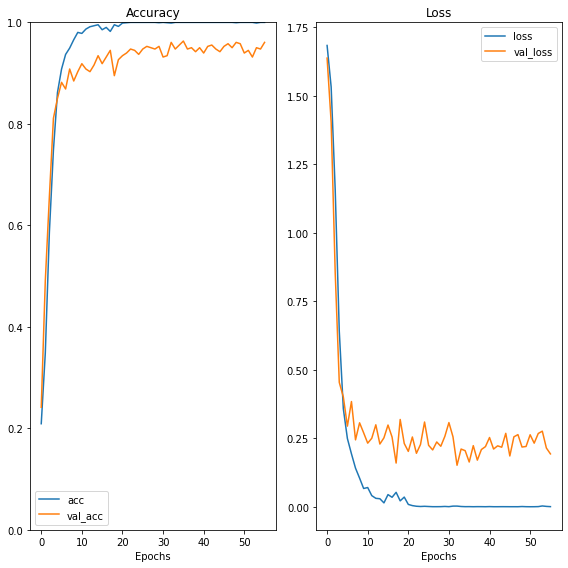

In [ ]:
plot_evaluate(result, model, test_images, test_labels_bin)

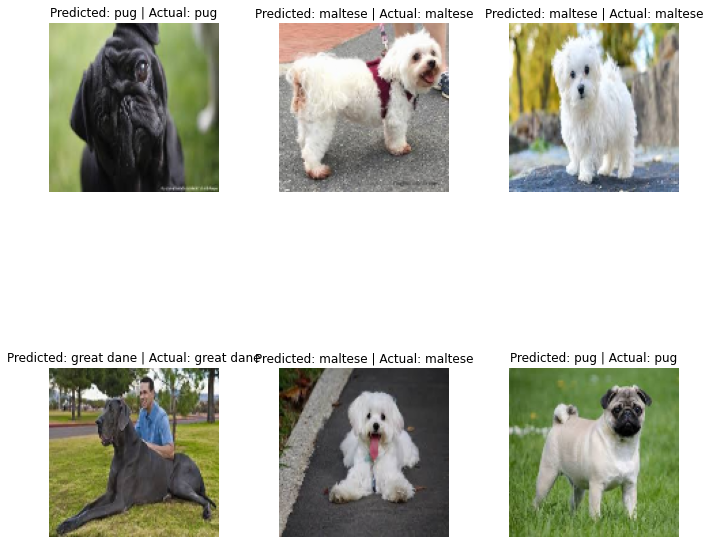

In [ ]:
show_img_prediction(discriminator, test_images, test_labels_bin)

Our model is performing phenomenally, not much signs of overfitting at all and amazing accuracy.

# Generative Adversarial Network




## Create Generator

In [ ]:
def make_generator_model():
    input1 = layers.Input(shape=(100,))
    flat = Flatten()(input1)
    hidden = Dense(7*7*256, use_bias=False)(flat)
    hidden = BatchNormalization()(hidden)
    hidden = LeakyReLU()(hidden)

    reshape = layers.Reshape((7, 7, 256))(hidden)

    hidden = layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)(reshape)
    hidden = BatchNormalization()(hidden)
    hidden = LeakyReLU()(hidden)

    hidden = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(hidden)
    hidden = BatchNormalization()(hidden)
    hidden = LeakyReLU()(hidden)

    hidden = layers.Conv2DTranspose(64, (5, 5), strides=(3, 3), padding='same', use_bias=False)(hidden)
    hidden = BatchNormalization()(hidden)
    hidden = LeakyReLU()(hidden)

    output = layers.Conv2DTranspose(3, (5, 5), strides=(3, 3), padding='same', use_bias=False, activation='tanh')(hidden)

    return tf.keras.Model(input1, output, name='generator')

In [ ]:
generator = make_generator_model()
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
flatten (Flatten)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         81

### Converting Y train data  
Converting so that labels aka the breed can be better represented when used to make an image.

Decided to remove this since the project has since shifted. It has proven to be too conflicting to do text to image generation.

In [ ]:

# newytrain = []
# count = 0
# print(len(ytrain))
# for i in range(len(ytrain)):
#     count+=1
#     noise = tf.random.normal([100,5])
#     index = np.argmax(ytrain[i])
#     rep = np.zeros((5,5))
#     rep[index,:] = 1
#     y = noise@rep
#     newytrain.append(y)


In [ ]:
# newytrain = np.asfarray(newytrain[0:1521])
# newytrain.shape

### Create Image Helper Function

Removed this create_image function since this was the old one to make an image with a "breed vector".

In [ ]:
# def create_image(gen, breed, training=False):
#     noise = tf.random.normal([100,5])
#     breed_rep = np.zeros((5,5))
#     breed_rep[label2index[breed],:] = 1
#     inp = np.expand_dims(noise@breed_rep, axis=0).astype(np.uint8)
#     generated_image = np.float32(generator(inp, training=training))
#     generated_image = generated_image[0]
#     return cv2.resize(generated_image,(125,125), interpolation=cv2.INTER_LINEAR)


In [ ]:
def create_image(gen):
    noise = tf.random.normal([1,100])
    gen_img = generator(noise, training=False).numpy()[0]
    image = (gen_img+1)/2
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off')
    return image

In [ ]:
generated_img = create_image(generator)
# print(generated_img.shape)
# plt.imshow(generated_img)

## Loading our pretrained classifier/discriminator

In [ ]:
# discriminator = load_model('drive/My Drive/models/leakyrelu_classifier', build_classifier_leaky())
# discriminator.compile(loss = "categorical_crossentropy", optimizer=opt, metrics=["acc"])

In [ ]:
# print('Untrained image tries to generate pug')
# generated_img = create_image(generator, 'pug')
# generated_img = np.expand_dims(generated_img, axis=0).astype(np.uint8)
# decision = discriminator(generated_img)
# print('Our trained model predicts:', index2label[np.argmax(decision)])

## Creating New Discriminator

In [ ]:
def make_discriminator_model():
    input1 = layers.Input(shape=(126, 126, 3))
    hidden = Conv2D(64, (5,5), strides=(2,2), padding='same')(input1)
    leakyrelu = layers.LeakyReLU()(hidden)
    pool = AveragePooling2D(pool_size=(2, 2))(leakyrelu)
    dropout = layers.Dropout(0.2)(pool)

    hidden = Conv2D(128, (5,5), strides=(2,2), padding='same')(dropout)
    leakyrelu = layers.LeakyReLU()(hidden)
    pool = AveragePooling2D(pool_size=(2, 2))(leakyrelu)
    dropout = layers.Dropout(0.2)(pool)

    hidden = Conv2D(256, (5,5), strides=(2,2), padding='same')(dropout)
    leakyrelu = layers.LeakyReLU()(hidden)
    pool = AveragePooling2D(pool_size=(2, 2))(leakyrelu)
    dropout = layers.Dropout(0.2)(pool)

    flatten = layers.Flatten()(dropout)
    # output = Dense(num_classes, activation="softmax")(flatten)
    output = Dense(1)(flatten)

    return tf.keras.Model(input1, output, name='disciminator')

In [ ]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "disciminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 126, 126, 3)]     0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 63, 63, 64)        4864      
_________________________________________________________________
leaky_re_lu_61 (LeakyReLU)   (None, 63, 63, 64)        0         
_________________________________________________________________
average_pooling2d_37 (Averag (None, 31, 31, 64)        0         
_________________________________________________________________
dropout_43 (Dropout)         (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 16, 16, 128)       204928    
_________________________________________________________________
leaky_re_lu_62 (LeakyReLU)   (None, 16, 16, 128)      

tf.Tensor([[-1.7419981e-05]], shape=(1, 1), dtype=float32)
Our untrained model predicts:


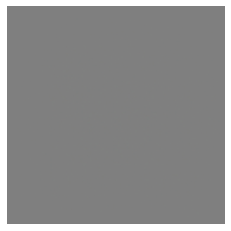

In [ ]:
noise = tf.random.normal([1,100])
generated_img = create_image(generator)
generated_img = generator(noise, training=False)
decision = discriminator(generated_img, training=False)
print(decision)
print('Our untrained model predicts:')

## Defining Our Loss Functions

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
gen_train_loss = tf.keras.metrics.Mean(name='train_loss')
disc_train_loss = tf.keras.metrics.Mean(name='train_loss')

In [ ]:
gen_path = os.path.join(os.getcwd(),'drive/My Drive/models/gan')
checkpoint_prefix = os.path.join(gen_path, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
noise_dim = 100
num_examples_to_generate = 9

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

## Setup for manual train steps

In [ ]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    gen_train_loss(gen_loss)
    disc_train_loss(disc_loss)

In [ ]:
gen_weights_path = os.path.join(gen_path,'generator')
disc_weights_path = os.path.join(gen_path,'discriminator')

In [ ]:
def train(dataset, epochs):
  tot_start = time.time()
  for epoch in range(epochs):
      start = time.time()

      for image_batch in dataset:
          train_step(image_batch)

      gen_losses.append(gen_train_loss.result().numpy())
      disc_losses.append(gen_train_loss.result().numpy())
      
      # Only every 5 to save time
      # Produce images for the GIF as we go
      if (epoch + 1) % 5 == 0:
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                epoch + 1,
                                seed)

      print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
      if (epoch + 1) % 100 == 0:
          generator.save_weights(gen_weights_path+str(epoch))
          discriminator.save_weights(disc_weights_path+str(epoch))
  # Generate and save after the final epoch
  # checkpoint.save(file_prefix = checkpoint_prefix)
  generator.save_weights(gen_weights_path)
  discriminator.save_weights(disc_weights_path)
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                          epochs,
                          seed)
  print_time(tot_start)

In [ ]:
def generate_and_save_images(model, epoch, name, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))
  for i in range(predictions.shape[0]):
      plt.subplot(3, 3, i+1)
      # image = predictions[i, :, :,].numpy()
      image = (predictions[i, :, :,].numpy()+1)/2
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      plt.imshow(image)
      plt.axis('off')
  plt.savefig('image{}_{:04d}.png'.format(name,epoch))
  plt.show()

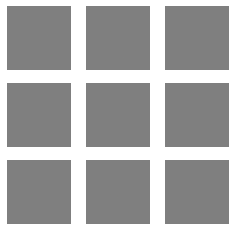

In [ ]:
generate_and_save_images(generator, 1, 'test', seed)

## Train

In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 64
train_dataset = tf.data.Dataset.from_tensor_slices(xtrain).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

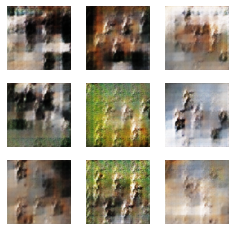

This took 34 minutes and 11.83 seconds


In [ ]:
gen_losses, disc_losses = [], []
start_train = time.time()
EPOCHS = 500
train(train_dataset, EPOCHS)

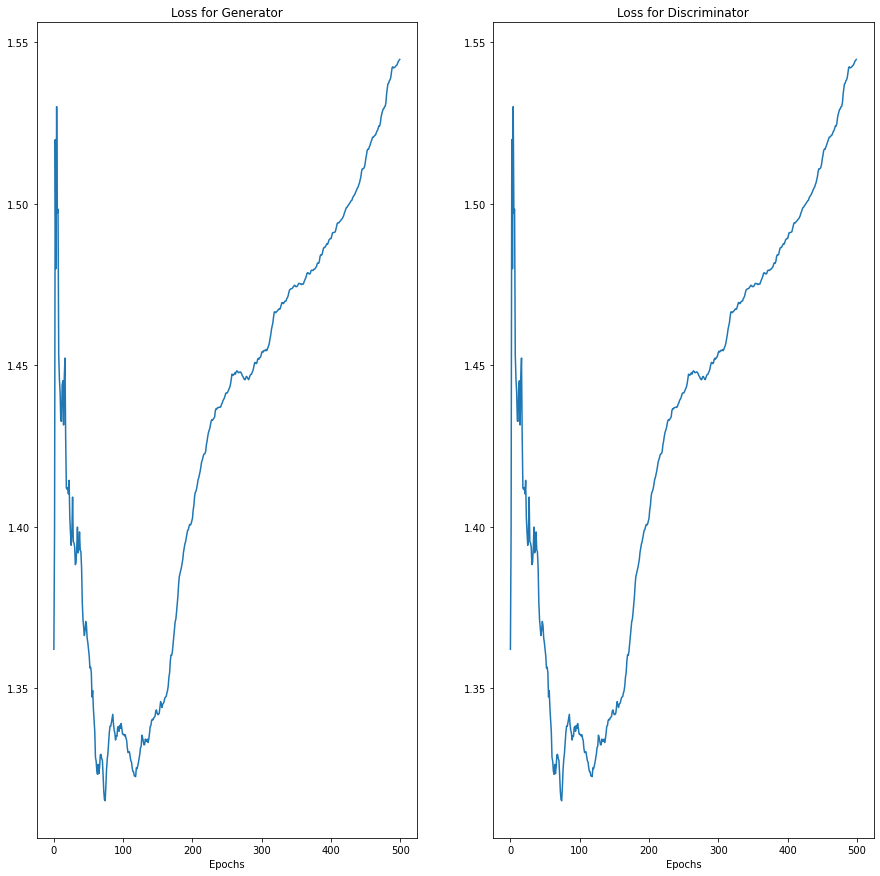

In [ ]:
plot_gan_loss(gen_losses, disc_losses, EPOCHS)

It seems that here our issue is that at a certain point our model is doing fairly well, but it begins to spiral out of control around epoch 100. I want to say it is because we need to either have some sort of warmup or learning rate decay. However it is hard to tell since gan's are normally trained for 1000+ epochs so there could've been another downtrend later on. 
  
The GIF below shows the training process and what images were created during training

![](https://drive.google.com/uc?export=view&id=1iszdd8sKBepLE5unYcGnz2gdpxDFjrpB)

## Prints Image at Epoch n

In [ ]:
 # Display a single image using the epoch number
def display_image(epoch_no):
  for i in os.listdir():
    if str(epoch_no) in i:
      print(i)
      return PIL.Image.open(i)

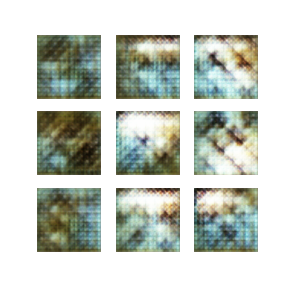

In [ ]:
display_image(100)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_prefix))

In [ ]:
def create_gif():
  anim_file = 'gan.gif'

  with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
      frame = 2*(i**0.5)
      if round(frame) > round(last):
        last = frame
      else:
        continue
      image = imageio.imread(filename)
      writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

  import IPython
  if IPython.version_info > (6,2,0,''):
    display.Image(filename=anim_file)

  try:
    from google.colab import files
  except ImportError:
    pass
  else:
    files.download(anim_file)

In [ ]:
def plot_gan_loss(gen_losses, disc_losses, epochs):
    # plotting the loss
    fig, axs = plt.subplots(1,2,figsize=(15,15), sharey=False)
    axs[0].plot(range(epochs),gen_losses)
    axs[0].title.set_text('Loss for Generator')
    axs[1].plot(range(epochs),disc_losses)
    axs[1].title.set_text('Loss for Discriminator')
    axs[0].set_xlabel('Epochs')
    axs[1].set_xlabel('Epochs')
    plt.show()

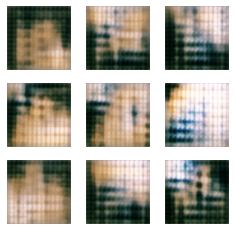

In [ ]:
generator.load_weights(gen_weights_path)
discriminator.load_weights(disc_weights_path)
generate_and_save_images(generator, 1, seed)

## Now Trying it for 1000 Epochs

In [ ]:
generator = make_generator_model()
discriminator = make_discriminator_model()
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
gen_train_loss = tf.keras.metrics.Mean(name='train_loss')
disc_train_loss = tf.keras.metrics.Mean(name='train_loss')
gen_path = os.path.join(os.getcwd(),'drive/My Drive/models/gan')
checkpoint_prefix = os.path.join(gen_path, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)
noise_dim = 100
num_examples_to_generate = 9
seed = tf.random.normal([num_examples_to_generate, noise_dim])
gen_weights_path = os.path.join(gen_path,'generator')
disc_weights_path = os.path.join(gen_path,'discriminator')
BUFFER_SIZE = 60000
BATCH_SIZE = 64
train_dataset = tf.data.Dataset.from_tensor_slices(xtrain).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

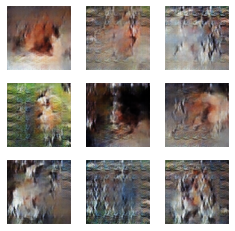

This took 68 minutes and 3.97 seconds


In [ ]:
gen_losses, disc_losses = [], []
start_train = time.time()
EPOCHS = 1000
train(train_dataset, EPOCHS)

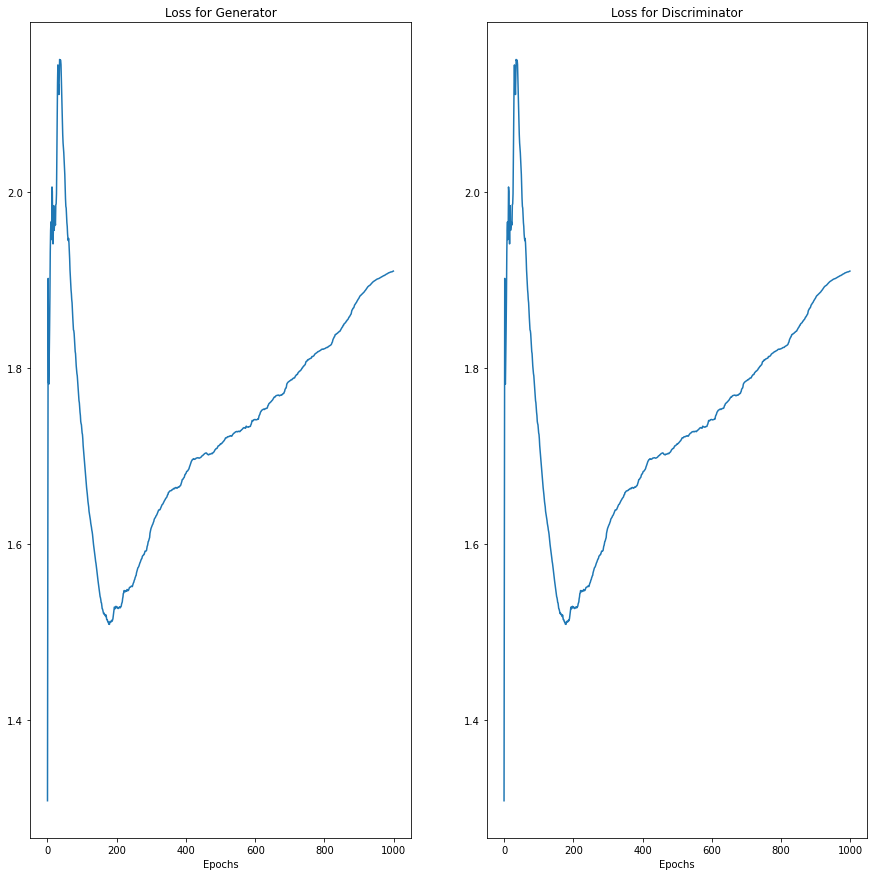

In [ ]:
plot_gan_loss(gen_losses, disc_losses, EPOCHS)

I did not change anything about the model besides increasing epochs to 1000 to see any possible trends. There is the same issues as before but loss's slope seems to be leveling off. So in the next problem I will try to implement warmup and decay and maybe some other changes.

![](https://drive.google.com/uc?export=view&id=1TBWm8n5IaYaNl6-ZiXBXC8j26TyGlJ-j)

178


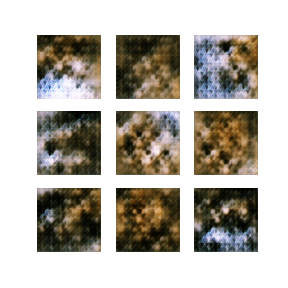

In [ ]:
# Since I am curious about the dip I will show the images created then
print(np.argmin(gen_losses[1:]))
display_image(170)

# 1000 Epochs + RAdam + Larger Batch Size + New Generator + (AND NEW DATA and NEW GENERATOR)
I tried cosine decay but there are so much errors no matter what I try  
  
![alt text](https://drive.google.com/uc?export=view&id=1tABOG3zdWKtR7UnLo4YT6axpjYMki_Oz)

![alt text](https://drive.google.com/uc?export=view&id=1Wxblh7x_dfa0ZtnbozpuEEMjcyElilYb)
  
I couldn't find any solutions for this kind of issue online either.  
  
![](https://drive.google.com/uc?export=view&id=13ywhlAiS5WMu2d4mN7G0E3dyoM1uya_6)  

And then even after all these issues... this happened. With an lucky opportunity to restart my training I decided to add more breeds into the dataset. Silky Terrier, Golden Retriever, and Japanese Spaniel were added.  
  
I also decided to add another conv layer to the generator model as well as some average pooling layers, and dropout layers.


In [ ]:
def make_generator_model():
    input1 = layers.Input(shape=(100,))
    flat = Flatten()(input1)
    hidden = Dense(7*7*256, use_bias=False)(flat)
    hidden = BatchNormalization()(hidden)
    hidden = LeakyReLU()(hidden)

    reshape = layers.Reshape((7, 7, 256))(hidden)

    hidden = layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)(reshape)
    hidden = BatchNormalization()(hidden)
    hidden = LeakyReLU()(hidden)
    pool = MaxPooling2D()(hidden)
    dropout = layers.Dropout(0.2)(pool)

    hidden = layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False)(hidden)
    hidden = BatchNormalization()(hidden)
    hidden = LeakyReLU()(hidden)
    pool = MaxPooling2D()(hidden)
    dropout = layers.Dropout(0.2)(pool)


    hidden = layers.Conv2DTranspose(64, (5, 5), strides=(3, 3), padding='same', use_bias=False)(hidden)
    hidden = BatchNormalization()(hidden)
    hidden = LeakyReLU()(hidden)

    hidden = layers.Conv2DTranspose(64, (5, 5), strides=(3, 3), padding='same', use_bias=False)(hidden)
    hidden = BatchNormalization()(hidden)
    hidden = LeakyReLU()(hidden)

    output = layers.Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh')(hidden)

    return tf.keras.Model(input1, output, name='generator')

In [ ]:
generator = make_generator_model()
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        [(None, 100)]             0         
_________________________________________________________________
flatten_26 (Flatten)         (None, 100)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 12544)             1254400   
_________________________________________________________________
batch_normalization_59 (Batc (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu_111 (LeakyReLU)  (None, 12544)             0         
_________________________________________________________________
reshape_12 (Reshape)         (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose_59 (Conv2DT (None, 7, 7, 128)         81

In [ ]:

discriminator = make_discriminator_model()
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
# generator_optimizer = tf.keras.optimizers.Adam(1e-4)
# discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
# learning_rate = tf.keras.experimental.CosineDecay(1e-4, 10000, alpha=0.1, name=None)
learning_rate = 1e-4
generator_optimizer = RectifiedAdam(
    lr=learning_rate,
    total_steps=10000,
    warmup_proportion=0.1,
    min_lr=1e-5,
)
discriminator_optimizer = RectifiedAdam(
    lr=learning_rate,
    total_steps=10000,
    warmup_proportion=0.1,
    min_lr=1e-5,
)

gen_train_loss = tf.keras.metrics.Mean(name='train_loss')
disc_train_loss = tf.keras.metrics.Mean(name='train_loss')
gen_path = os.path.join(os.getcwd(),'drive/My Drive/models/gan')

noise_dim = 100
num_examples_to_generate = 9
seed = tf.random.normal([num_examples_to_generate, noise_dim])
gen_weights_path = os.path.join(gen_path,'gen_v2')
disc_weights_path = os.path.join(gen_path,'disc_v2')
BUFFER_SIZE = 60000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(xtrain).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

Redefining the functions because for some reason it forces me to re-call them

In [ ]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    gen_train_loss(gen_loss)
    disc_train_loss(disc_loss)

In [ ]:
def train(dataset, epochs):
  tot_start = time.time()
  for epoch in range(epochs):
      start = time.time()

      for image_batch in dataset:
          train_step(image_batch)

      gen_lossesv2.append(gen_train_loss.result().numpy())
      disc_lossesv2.append(gen_train_loss.result().numpy())
      
      # Only every 25 to save time
      # Produce images for the GIF as we go
      if (epoch + 1) % 25 == 0:
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                epoch + 1, 'v2',
                                seed)

      print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
      if (epoch + 1) % 100 == 0:
          generator.save_weights(gen_weights_path+str(epoch))
          discriminator.save_weights(disc_weights_path+str(epoch))
  # Generate and save after the final epoch
  # checkpoint.save(file_prefix = checkpoint_prefix)
  generator.save_weights(gen_weights_path)
  discriminator.save_weights(disc_weights_path)
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                          epochs,'v2',
                          seed)
  print_time(tot_start)

In [ ]:
# # clear old images
# for i in os.listdir():
#     if 'image_at' in i:
#         os.remove(i)

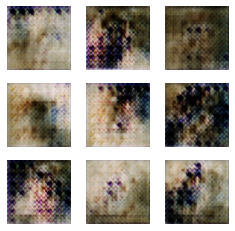

This took 88 minutes and 7.41 seconds


In [ ]:
gen_lossesv2, disc_lossesv2 = [], []
start_train = time.time()
EPOCHS = 1000
train(train_dataset, EPOCHS)

imagev2_1000.png


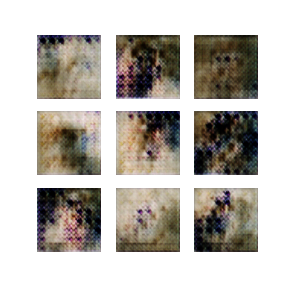

In [ ]:
display_image(1000)

Going to leave the error here to show how hours of training went to waste because loss logs didnt save properly :(
  

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

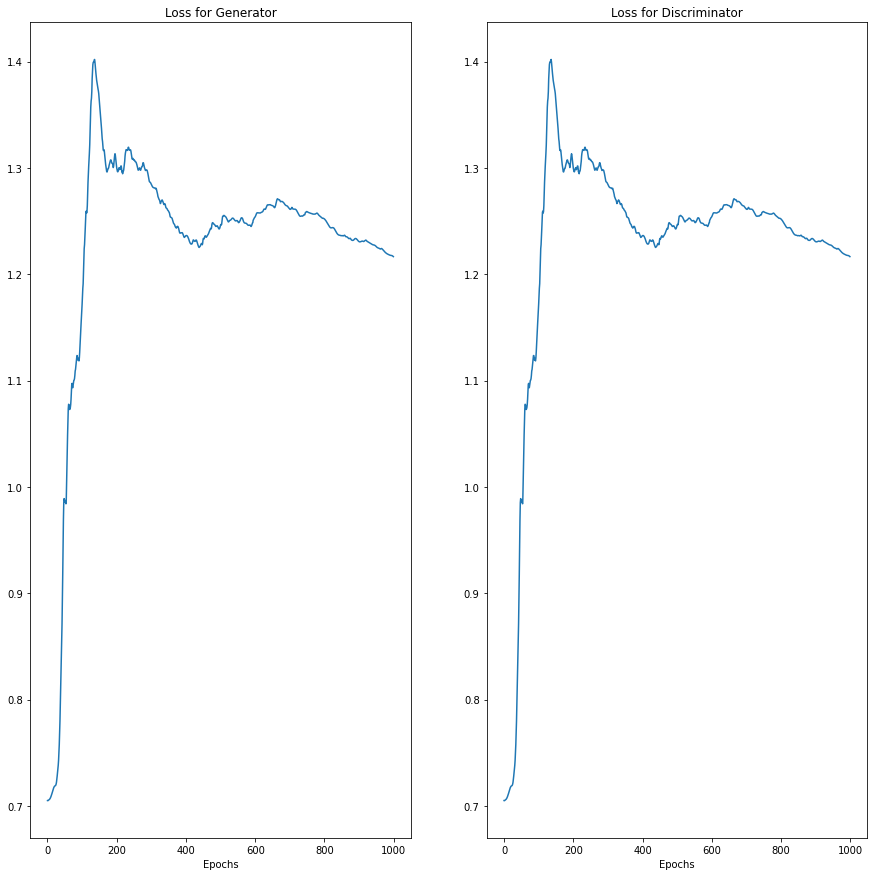

In [ ]:
create_gif()
plot_gan_loss(gen_lossesv2, disc_lossesv2,len(gen_lossesv2))

As we can see the loss is starting to downtrend again. So it seems that the changes we implemented are working, so with little changes I think in the next one we just have to try training for a lot of epochs and seeing what happens. The gif failed to save for this set of training sadly, more colab runtime issues.

# One Last Try 5000 Epochs(kind of)! Smaller Image

In [ ]:
def make_generator_model():
    input1 = layers.Input(shape=(100,))
    flat = Flatten()(input1)
    hidden = Dense(7*7*256, use_bias=False)(flat)
    hidden = BatchNormalization()(hidden)
    hidden = LeakyReLU()(hidden)

    reshape = layers.Reshape((7, 7, 256))(hidden)

    hidden = layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)(reshape)
    hidden = BatchNormalization()(hidden)
    hidden = LeakyReLU()(hidden)
    pool = MaxPooling2D()(hidden)
    dropout = layers.Dropout(0.2)(pool)

    hidden = layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False)(hidden)
    hidden = BatchNormalization()(hidden)
    hidden = LeakyReLU()(hidden)
    pool = MaxPooling2D()(hidden)
    dropout = layers.Dropout(0.2)(pool)


    hidden = layers.Conv2DTranspose(64, (5, 5), strides=(3, 3), padding='same', use_bias=False)(hidden)
    hidden = BatchNormalization()(hidden)
    hidden = LeakyReLU()(hidden)

    hidden = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(hidden)
    hidden = BatchNormalization()(hidden)
    hidden = LeakyReLU()(hidden)

    output = layers.Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh')(hidden)

    return tf.keras.Model(input1, output, name='generator')

In [ ]:
generator = make_generator_model()
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
flatten (Flatten)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         81

In [ ]:
def make_discriminator_model():
    input1 = layers.Input(shape=(84, 84, 3))
    hidden = Conv2D(64, (5,5), strides=(2,2), padding='same')(input1)
    leakyrelu = layers.LeakyReLU()(hidden)
    pool = AveragePooling2D(pool_size=(2, 2))(leakyrelu)
    dropout = layers.Dropout(0.2)(pool)

    hidden = Conv2D(128, (5,5), strides=(2,2), padding='same')(dropout)
    leakyrelu = layers.LeakyReLU()(hidden)
    pool = AveragePooling2D(pool_size=(2, 2))(leakyrelu)
    dropout = layers.Dropout(0.2)(pool)

    hidden = Conv2D(256, (5,5), strides=(2,2), padding='same')(dropout)
    leakyrelu = layers.LeakyReLU()(hidden)
    pool = AveragePooling2D(pool_size=(2, 2))(leakyrelu)
    dropout = layers.Dropout(0.2)(pool)

    flatten = layers.Flatten()(dropout)
    # output = Dense(num_classes, activation="softmax")(flatten)
    output = Dense(1)(flatten)

    return tf.keras.Model(input1, output, name='disciminator')

In [ ]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "disciminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 84, 84, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 42, 42, 64)        4864      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 42, 42, 64)        0         
_________________________________________________________________
average_pooling2d (AveragePo (None, 21, 21, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 21, 21, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 128)       204928    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 11, 11, 128)      

In [ ]:
def prep_data(directory):
    start_time = time.time()
    x, y = [], []
    for filename in os.listdir(directory):
        y.append(filename)
        img = cv2.resize(cv2.imread(os.path.join(directory,filename)),(84,84), interpolation=cv2.INTER_LINEAR)
        img = negnorm_image(img)
        # img = norm_image(img)
        x.append(img)
        # to double our dataset size and sort of add more variance slightly to our data
        # dont want to only recognize a pug if it faces to the right
        x.append(cv2.flip(img,1))
    print_time(start_time)
    return np.asarray(x),np.asarray(y)

In [ ]:
path = 'drive/My Drive/data/processed_data/processed_data'
train, labels = prep_data(path)

This took 0 minutes and 5.04 seconds


In [ ]:

discriminator = make_discriminator_model()
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
# generator_optimizer = tf.keras.optimizers.Adam(1e-4)
# discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
# learning_rate = tf.keras.experimental.CosineDecay(1e-4, 10000, alpha=0.1, name=None)
learning_rate = 1e-4
generator_optimizer = RectifiedAdam(
    lr=learning_rate,
    total_steps=10000,
    warmup_proportion=0.1,
    min_lr=1e-5,
)
discriminator_optimizer = RectifiedAdam(
    lr=learning_rate,
    total_steps=10000,
    warmup_proportion=0.1,
    min_lr=1e-5,
)

gen_train_loss = tf.keras.metrics.Mean(name='train_loss')
disc_train_loss = tf.keras.metrics.Mean(name='train_loss')
gen_path = os.path.join(os.getcwd(),'drive/My Drive/models/gan')

noise_dim = 100
num_examples_to_generate = 9
seed = tf.random.normal([num_examples_to_generate, noise_dim])
gen_weights_path = os.path.join(gen_path,'gen_v3')
disc_weights_path = os.path.join(gen_path,'disc_v3')
BUFFER_SIZE = 60000
BATCH_SIZE = 128
train_dataset = tf.data.Dataset.from_tensor_slices(train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    gen_train_loss(gen_loss)
    disc_train_loss(disc_loss)

In [ ]:
def train(dataset, epochs):
  tot_start = time.time()
  for epoch in range(epochs):
      start = time.time()

      for image_batch in dataset:
          train_step(image_batch)

      gen_lossesv3.append(gen_train_loss.result().numpy())
      disc_lossesv3.append(gen_train_loss.result().numpy())
      
      # Only every 25 to save time
      # Produce images for the GIF as we go
      if (epoch + 1) % 25 == 0:
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                epoch + 1, 'v2',
                                seed)

      print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
      if (epoch + 1) % 100 == 0:
          generator.save_weights(gen_weights_path+str(epoch))
          discriminator.save_weights(disc_weights_path+str(epoch))
  # Generate and save after the final epoch
  # checkpoint.save(file_prefix = checkpoint_prefix)
  generator.save_weights(gen_weights_path)
  discriminator.save_weights(disc_weights_path)
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                          epochs,'v3',
                          seed)
  print_time(tot_start)

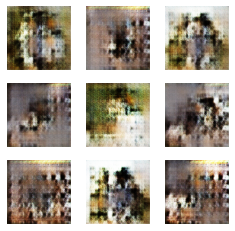

This took 9 minutes and 25.1 seconds


In [ ]:
gen_lossesv3, disc_lossesv3 = [], []
start_train = time.time()
EPOCHS = 3
train(train_dataset, EPOCHS)

![](https://drive.google.com/uc?export=view&id=1NdQx5jXLObFCBJtgDgDsXmQriI4CoYRG)

I woke up to this. I even wrote a script to do random inputs periodically on colab in order to not get disconnected for being idle. Had to reload the weights after colab completely cutting off all GPU runtimes for me when I got to around 2000 epochs. I tried to load the history but it didn't work so I don't even have the loss chart now. And now it looks like a single epoch takes 3 minutes so the feasibility of me doing 1000+ epochs is basically none. I am glad however I was at least able to load the weights, see below.

weights loaded, image generated from loaded model:


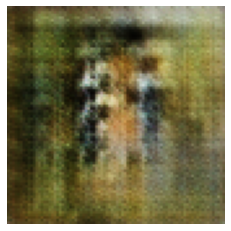

In [ ]:
generator.load_weights(gen_weights_path+'1999')
discriminator.load_weights(disc_weights_path+'1999')
create_image(generator)
print('weights loaded, image generated from loaded model:')

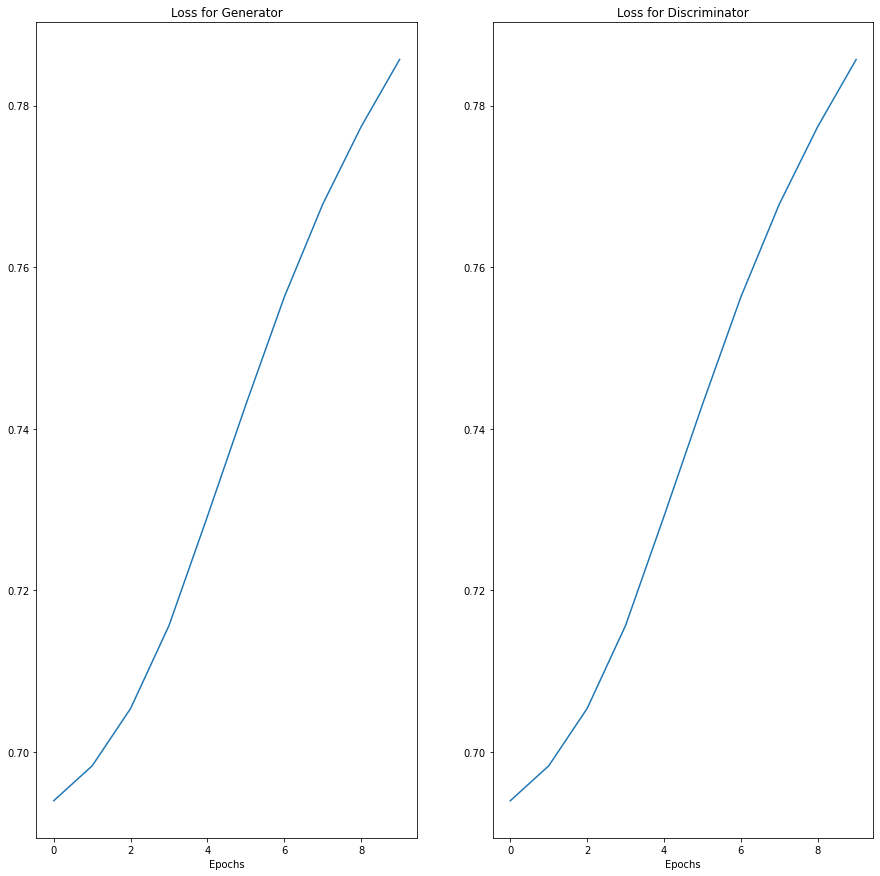

In [ ]:
# create_gif()
plot_gan_loss(gen_lossesv3, disc_lossesv3,len(gen_lossesv3))

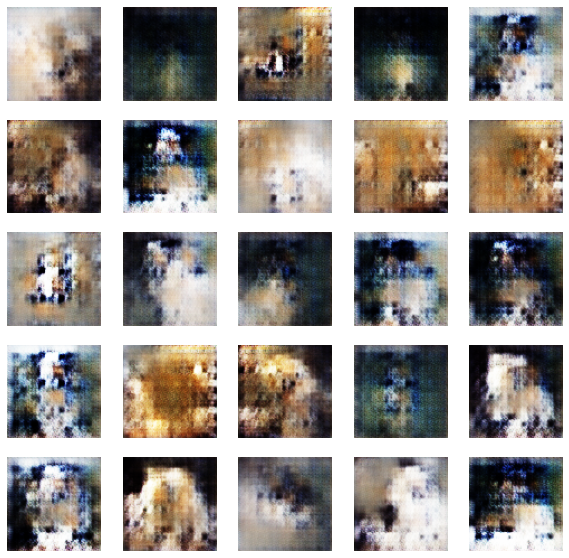

In [ ]:
last_seed = tf.random.normal([25, 100])
generated_images = generator(last_seed)
fig,axs = plt.subplots(5,5,figsize=(10,10))
for img in range(len(generated_images)):
    plt.subplot(5, 5, img+1)
    image = (generated_images[img].numpy()+1)/2
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off')

# Conclusion  

Based on the loss from the few epochs I can train it for now, it looks like the loss got below 1!!! This is great(at least for me) after seeing for all other attempts be over 1 or over 2 even. After the results from the 1000 epoch with radam and etc, I was really excited about trying 5000 with some tweaks but alas colab has its limits.  
  
I still think the images generated were (relatively) good however. At least compared to all other images generated before it. I still want to try this model in the future it looks promising! It can still be fine tuned and I think I need to maybe switch up the data(it looks like all the different positions of dogs cause the eyes(black dots in the photos) to be everywhere.

All in all, despite all the issues and bugs with this project I am very happy with how it turned out and happy with how much I learned. I feel so accomplished being able to put everything I learned in this class into something completely of my own.  
  
## **THANK YOU PROFESSORS & SHIVAS !!**  
## **This was an amazing class !!**

# Backup Plan!

In [ ]:
def fake_generator(breed):
    pics = processed_data[breed]
    doggos = sample(pics,3)
    fig, axs = plt.subplots(1,3,figsize=(15,15))
    for i in range(len(doggos)):
      dog = np.uint8((doggos[i]*127.5)+127.5)
      image = cv2.cvtColor(dog, cv2.COLOR_BGR2RGB)
      axs[i].imshow(image)
      axs[i].axis('off')

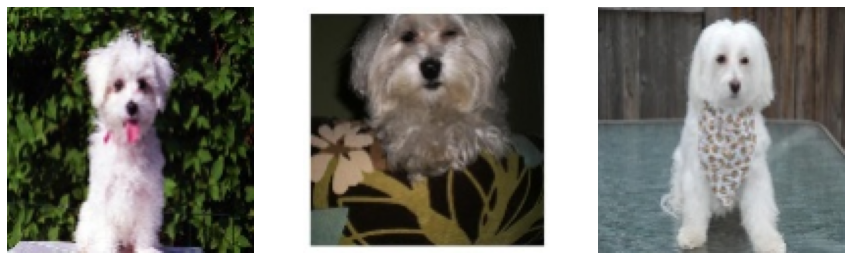

In [ ]:
fake_generator('maltese')